# Method 5 - Best Ideas Medium Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['size_pct'] > (1 / 3)) & (best_ideas['size_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

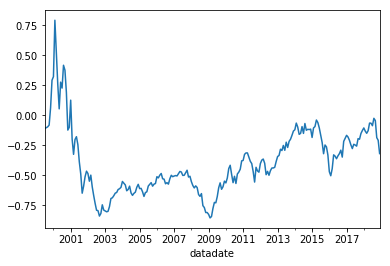

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.293052
2000-12-31   -0.303771
2001-12-31   -0.406294
2002-12-31   -0.607182
2003-12-31    0.903324
2004-12-31    0.062714
2005-12-31    0.016098
2006-12-31    0.132242
2007-12-31    0.007231
2008-12-31   -0.614828
2009-12-31    1.380215
2010-12-31    0.375042
2011-12-31   -0.152218
2012-12-31    0.169153
2013-12-31    0.412919
2014-12-31    0.018774
2015-12-31   -0.244360
2016-12-31    0.207750
2017-12-31    0.081685
2018-12-31   -0.220599
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     293.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.71e-89
Time:                        04:45:03   Log-Likelihood:                 390.31
No. Observations:                 234   AIC:                            -770.6
Df Residuals:                     229   BIC:                            -753.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.520      0.604      -0.005       0.008
mktrf          1.4046      0.086     16.323      0.000       1.235       1.574
me             0.7012      0.100      7.005      0.000       0.504       0.898
ia            -0.1511      0.152     -0.993      0.322      -0.451       0.149
roe           -1.3709      0.130    -10.528      0.000      -1.628      -1.114
==============================================================================
Omnibus:                      117.786   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1376.971
Skew:                           1.652   Prob(JB):                    9.88e-300
Kurtosis:                      14.415   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     137.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.25e-59
Time:                        04:45:03   Log-Likelihood:                 390.31
No. Observations:                 234   AIC:                            -770.6
Df Residuals:                     229   BIC:                            -753.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.542      0.587      -0.004       0.008
mktrf          1.4046      0.160      8.774      0.000       1.091       1.718
me             0.7012      0.149      4.699      0.000       0.409       0.994
ia            -0.1511      0.215     -0.703      0.482      -0.572       0.270
roe           -1.3709      0.220     -6.221      0.000      -1.803      -0.939
==============================================================================
Omnibus:                      117.786   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1376.971
Skew:                           1.652   Prob(JB):                    9.88e-300
Kurtosis:                      14.415   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     181.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.06e-69
Time:                        04:45:03   Log-Likelihood:                 390.31
No. Observations:                 234   AIC:                            -770.6
Df Residuals:                     229   BIC:                            -753.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.003      0.535      0.592      -0.004       0.008
mktrf          1.4046      0.164      8.577      0.000       1.084       1.726
me             0.7012      0.163      4.305      0.000       0.382       1.020
ia            -0.1511      0.206     -0.732      0.464      -0.555       0.253
roe           -1.3709      0.237     -5.779      0.000      -1.836      -0.906
==============================================================================
Omnibus:                      117.786   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1376.971
Skew:                           1.652   Prob(JB):                    9.88e-300
Kurtosis:                      14.415   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     216.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.89e-84
Time:                        04:45:03   Log-Likelihood:                 382.75
No. Observations:                 234   AIC:                            -753.5
Df Residuals:                     228   BIC:                            -732.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.255      0.799      -0.006       0.007
mktrf          1.5436      0.089     17.297      0.000       1.368       1.719
smb            0.6691      0.118      5.682      0.000       0.437       0.901
hml            0.0701      0.139      0.505      0.614      -0.203       0.344
rmw           -1.3453      0.157     -8.569      0.000      -1.655      -1.036
cma            0.1558      0.200      0.781      0.436      -0.237       0.549
==============================================================================
Omnibus:                      107.985   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.212
Skew:                           1.690   Prob(JB):                    1.21e-153
Kurtosis:                      10.798   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     156.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.56e-71
Time:                        04:45:04   Log-Likelihood:                 382.75
No. Observations:                 234   AIC:                            -753.5
Df Residuals:                     228   BIC:                            -732.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.271      0.786      -0.005       0.007
mktrf          1.5436      0.094     16.365      0.000       1.359       1.729
smb            0.6691      0.113      5.907      0.000       0.447       0.891
hml            0.0701      0.259      0.271      0.787      -0.437       0.578
rmw           -1.3453      0.203     -6.624      0.000      -1.743      -0.947
cma            0.1558      0.303      0.514      0.607      -0.439       0.750
==============================================================================
Omnibus:                      107.985   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.212
Skew:                           1.690   Prob(JB):                    1.21e-153
Kurtosis:                      10.798   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     187.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-78
Time:                        04:45:04   Log-Likelihood:                 382.75
No. Observations:                 234   AIC:                            -753.5
Df Residuals:                     228   BIC:                            -732.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.003      0.260      0.795      -0.006       0.007
mktrf          1.5436      0.087     17.732      0.000       1.373       1.714
smb            0.6691      0.121      5.542      0.000       0.432       0.906
hml            0.0701      0.227      0.309      0.758      -0.375       0.515
rmw           -1.3453      0.210     -6.399      0.000      -1.757      -0.933
cma            0.1558      0.274      0.569      0.569      -0.381       0.693
==============================================================================
Omnibus:                      107.985   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.212
Skew:                           1.690   Prob(JB):                    1.21e-153
Kurtosis:                      10.798   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     247.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.03e-82
Time:                        04:45:04   Log-Likelihood:                 373.92
No. Observations:                 234   AIC:                            -737.8
Df Residuals:                     229   BIC:                            -720.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -0.951      0.343      -0.010       0.003
mktrf          1.6415      0.085     19.318      0.000       1.474       1.809
smb            1.2986      0.106     12.243      0.000       1.090       1.508
hml           -0.2052      0.105     -1.948      0.053      -0.413       0.002
umd           -0.4679      0.069     -6.768      0.000      -0.604      -0.332
==============================================================================
Omnibus:                       91.480   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.644
Skew:                           1.371   Prob(JB):                    3.73e-131
Kurtosis:                      10.355   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     99.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.32e-49
Time:                        04:45:04   Log-Likelihood:                 373.92
No. Observations:                 234   AIC:                            -737.8
Df Residuals:                     229   BIC:                            -720.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.038      0.299      -0.009       0.003
mktrf          1.6415      0.128     12.859      0.000       1.391       1.892
smb            1.2986      0.147      8.859      0.000       1.011       1.586
hml           -0.2052      0.171     -1.197      0.231      -0.541       0.131
umd           -0.4679      0.115     -4.064      0.000      -0.694      -0.242
==============================================================================
Omnibus:                       91.480   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.644
Skew:                           1.371   Prob(JB):                    3.73e-131
Kurtosis:                      10.355   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     89.08
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-45
Time:                        04:45:04   Log-Likelihood:                 373.92
No. Observations:                 234   AIC:                            -737.8
Df Residuals:                     229   BIC:                            -720.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.052      0.293      -0.009       0.003
mktrf          1.6415      0.129     12.771      0.000       1.390       1.893
smb            1.2986      0.143      9.086      0.000       1.018       1.579
hml           -0.2052      0.166     -1.233      0.218      -0.531       0.121
umd           -0.4679      0.119     -3.935      0.000      -0.701      -0.235
==============================================================================
Omnibus:                       91.480   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.644
Skew:                           1.371   Prob(JB):                    3.73e-131
Kurtosis:                      10.355   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     139.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.76e-43
Time:                        04:45:04   Log-Likelihood:                 177.62
No. Observations:                 120   AIC:                            -345.2
Df Residuals:                     115   BIC:                            -331.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.005      0.873      0.385      -0.006       0.015
mktrf          1.2913      0.145      8.905      0.000       1.004       1.579
me             0.6215      0.143      4.339      0.000       0.338       0.905
ia            -0.3784      0.224     -1.687      0.094      -0.823       0.066
roe           -1.4195      0.199     -7.151      0.000      -1.813      -1.026
==============================================================================
Omnibus:                       51.107   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.244
Skew:                           1.285   Prob(JB):                     9.42e-64
Kurtosis:                      10.172   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     102.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.56e-37
Time:                        04:45:04   Log-Likelihood:                 177.62
No. Observations:                 120   AIC:                            -345.2
Df Residuals:                     115   BIC:                            -331.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.045      0.296      -0.004       0.013
mktrf          1.2913      0.255      5.055      0.000       0.791       1.792
me             0.6215      0.202      3.069      0.002       0.225       1.018
ia            -0.3784      0.308     -1.230      0.219      -0.981       0.224
roe           -1.4195      0.323     -4.400      0.000      -2.052      -0.787
==============================================================================
Omnibus:                       51.107   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.244
Skew:                           1.285   Prob(JB):                     9.42e-64
Kurtosis:                      10.172   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     166.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.96e-47
Time:                        04:45:04   Log-Likelihood:                 177.62
No. Observations:                 120   AIC:                            -345.2
Df Residuals:                     115   BIC:                            -331.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0047      0.004      1.163      0.245      -0.003       0.013
mktrf          1.2913      0.266      4.852      0.000       0.770       1.813
me             0.6215      0.220      2.825      0.005       0.190       1.053
ia            -0.3784      0.286     -1.323      0.186      -0.939       0.182
roe           -1.4195      0.357     -3.977      0.000      -2.119      -0.720
==============================================================================
Omnibus:                       51.107   Durbin-Watson:                   2.138
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              290.244
Skew:                           1.285   Prob(JB):                     9.42e-64
Kurtosis:                      10.172   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     107.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.11e-41
Time:                        04:45:04   Log-Likelihood:                 176.04
No. Observations:                 120   AIC:                            -340.1
Df Residuals:                     114   BIC:                            -323.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.006      1.055      0.294      -0.005       0.017
mktrf          1.5932      0.156     10.239      0.000       1.285       1.901
smb            0.6043      0.176      3.429      0.001       0.255       0.953
hml           -0.2161      0.216     -1.001      0.319      -0.644       0.212
rmw           -1.1946      0.255     -4.691      0.000      -1.699      -0.690
cma            0.2153      0.279      0.772      0.442      -0.337       0.768
==============================================================================
Omnibus:                       58.784   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.743
Skew:                           1.687   Prob(JB):                     1.18e-53
Kurtosis:                       9.112   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     75.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-34
Time:                        04:45:04   Log-Likelihood:                 176.04
No. Observations:                 120   AIC:                            -340.1
Df Residuals:                     114   BIC:                            -323.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.004      1.509      0.131      -0.002       0.014
mktrf          1.5932      0.168      9.488      0.000       1.264       1.922
smb            0.6043      0.164      3.674      0.000       0.282       0.927
hml           -0.2161      0.257     -0.841      0.400      -0.720       0.288
rmw           -1.1946      0.272     -4.387      0.000      -1.728      -0.661
cma            0.2153      0.329      0.655      0.512      -0.429       0.860
==============================================================================
Omnibus:                       58.784   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.743
Skew:                           1.687   Prob(JB):                     1.18e-53
Kurtosis:                       9.112   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     94.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.14e-39
Time:                        04:45:04   Log-Likelihood:                 176.04
No. Observations:                 120   AIC:                            -340.1
Df Residuals:                     114   BIC:                            -323.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.004      1.691      0.091      -0.001       0.013
mktrf          1.5932      0.138     11.508      0.000       1.322       1.865
smb            0.6043      0.161      3.743      0.000       0.288       0.921
hml           -0.2161      0.243     -0.889      0.374      -0.692       0.260
rmw           -1.1946      0.287     -4.156      0.000      -1.758      -0.631
cma            0.2153      0.276      0.780      0.435      -0.326       0.756
==============================================================================
Omnibus:                       58.784   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.743
Skew:                           1.687   Prob(JB):                     1.18e-53
Kurtosis:                       9.112   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     134.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.91e-42
Time:                        04:45:04   Log-Likelihood:                 175.91
No. Observations:                 120   AIC:                            -341.8
Df Residuals:                     115   BIC:                            -327.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.005      0.140      0.889      -0.010       0.011
mktrf          1.6708      0.130     12.894      0.000       1.414       1.927
smb            1.2334      0.148      8.361      0.000       0.941       1.526
hml           -0.4795      0.148     -3.245      0.002      -0.772      -0.187
umd           -0.4397      0.091     -4.826      0.000      -0.620      -0.259
==============================================================================
Omnibus:                       49.513   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.798
Skew:                           1.342   Prob(JB):                     5.08e-48
Kurtosis:                       9.030   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     93.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.96e-35
Time:                        04:45:04   Log-Likelihood:                 175.91
No. Observations:                 120   AIC:                            -341.8
Df Residuals:                     115   BIC:                            -327.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.004      0.186      0.852      -0.007       0.009
mktrf          1.6708      0.186      8.970      0.000       1.306       2.036
smb            1.2334      0.162      7.604      0.000       0.915       1.551
hml           -0.4795      0.211     -2.276      0.023      -0.892      -0.067
umd           -0.4397      0.119     -3.685      0.000      -0.674      -0.206
==============================================================================
Omnibus:                       49.513   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.798
Skew:                           1.342   Prob(JB):                     5.08e-48
Kurtosis:                       9.030   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     130.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.94e-42
Time:                        04:45:04   Log-Likelihood:                 175.91
No. Observations:                 120   AIC:                            -341.8
Df Residuals:                     115   BIC:                            -327.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.004      0.211      0.833      -0.006       0.008
mktrf          1.6708      0.195      8.582      0.000       1.289       2.052
smb            1.2334      0.159      7.765      0.000       0.922       1.545
hml           -0.4795      0.214     -2.236      0.025      -0.900      -0.059
umd           -0.4397      0.125     -3.508      0.000      -0.685      -0.194
==============================================================================
Omnibus:                       49.513   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              217.798
Skew:                           1.342   Prob(JB):                     5.08e-48
Kurtosis:                       9.030   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     185.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.18e-47
Time:                        04:45:04   Log-Likelihood:                 234.71
No. Observations:                 114   AIC:                            -459.4
Df Residuals:                     109   BIC:                            -445.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.474      0.637      -0.008       0.005
mktrf          1.4975      0.093     16.131      0.000       1.314       1.681
me             0.8256      0.143      5.760      0.000       0.541       1.110
ia             0.3007      0.199      1.512      0.133      -0.093       0.695
roe           -1.3182      0.175     -7.546      0.000      -1.664      -0.972
==============================================================================
Omnibus:                       30.165   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.208
Skew:                           1.074   Prob(JB):                     5.12e-14
Kurtosis:                       5.876   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     191.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.20e-48
Time:                        04:45:04   Log-Likelihood:                 234.71
No. Observations:                 114   AIC:                            -459.4
Df Residuals:                     109   BIC:                            -445.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.604      0.546      -0.006       0.003
mktrf          1.4975      0.095     15.806      0.000       1.312       1.683
me             0.8256      0.164      5.020      0.000       0.503       1.148
ia             0.3007      0.237      1.268      0.205      -0.164       0.765
roe           -1.3182      0.260     -5.070      0.000      -1.828      -0.809
==============================================================================
Omnibus:                       30.165   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.208
Skew:                           1.074   Prob(JB):                     5.12e-14
Kurtosis:                       5.876   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     207.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.30e-50
Time:                        04:45:04   Log-Likelihood:                 234.71
No. Observations:                 114   AIC:                            -459.4
Df Residuals:                     109   BIC:                            -445.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.002     -0.706      0.480      -0.006       0.003
mktrf          1.4975      0.088     16.987      0.000       1.325       1.670
me             0.8256      0.191      4.328      0.000       0.452       1.199
ia             0.3007      0.269      1.120      0.263      -0.226       0.827
roe           -1.3182      0.268     -4.911      0.000      -1.844      -0.792
==============================================================================
Omnibus:                       30.165   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.208
Skew:                           1.074   Prob(JB):                     5.12e-14
Kurtosis:                       5.876   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     134.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.99e-45
Time:                        04:45:04   Log-Likelihood:                 230.40
No. Observations:                 114   AIC:                            -448.8
Df Residuals:                     108   BIC:                            -432.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.003     -1.128      0.262      -0.010       0.003
mktrf          1.5389      0.092     16.661      0.000       1.356       1.722
smb            0.7710      0.150      5.142      0.000       0.474       1.068
hml            0.6518      0.191      3.408      0.001       0.273       1.031
rmw           -1.1406      0.234     -4.871      0.000      -1.605      -0.676
cma           -0.0807      0.297     -0.271      0.787      -0.670       0.509
==============================================================================
Omnibus:                       19.711   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.393
Skew:                           0.765   Prob(JB):                     5.61e-08
Kurtosis:                       5.165   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     163.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.12e-48
Time:                        04:45:04   Log-Likelihood:                 230.40
No. Observations:                 114   AIC:                            -448.8
Df Residuals:                     108   BIC:                            -432.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.004     -1.047      0.295      -0.011       0.003
mktrf          1.5389      0.073     21.211      0.000       1.397       1.681
smb            0.7710      0.141      5.483      0.000       0.495       1.047
hml            0.6518      0.198      3.284      0.001       0.263       1.041
rmw           -1.1406      0.299     -3.819      0.000      -1.726      -0.555
cma           -0.0807      0.288     -0.280      0.779      -0.644       0.483
==============================================================================
Omnibus:                       19.711   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.393
Skew:                           0.765   Prob(JB):                     5.61e-08
Kurtosis:                       5.165   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     203.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.72e-53
Time:                        04:45:04   Log-Likelihood:                 230.40
No. Observations:                 114   AIC:                            -448.8
Df Residuals:                     108   BIC:                            -432.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0037      0.004     -1.047      0.295      -0.011       0.003
mktrf          1.5389      0.070     21.893      0.000       1.401       1.677
smb            0.7710      0.158      4.876      0.000       0.461       1.081
hml            0.6518      0.175      3.723      0.000       0.309       0.995
rmw           -1.1406      0.270     -4.231      0.000      -1.669      -0.612
cma           -0.0807      0.311     -0.259      0.795      -0.690       0.529
==============================================================================
Omnibus:                       19.711   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.393
Skew:                           0.765   Prob(JB):                     5.61e-08
Kurtosis:                       5.165   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     148.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.98e-43
Time:                        04:45:04   Log-Likelihood:                 223.77
No. Observations:                 114   AIC:                            -437.5
Df Residuals:                     109   BIC:                            -423.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.003     -1.348      0.180      -0.012       0.002
mktrf          1.5759      0.097     16.275      0.000       1.384       1.768
smb            1.0408      0.151      6.894      0.000       0.742       1.340
hml            0.6307      0.155      4.056      0.000       0.323       0.939
umd           -0.3914      0.117     -3.337      0.001      -0.624      -0.159
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.918
Skew:                           0.777   Prob(JB):                     7.20e-13
Kurtosis:                       6.058   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     212.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.58e-50
Time:                        04:45:04   Log-Likelihood:                 223.77
No. Observations:                 114   AIC:                            -437.5
Df Residuals:                     109   BIC:                            -423.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.003     -1.489      0.137      -0.011       0.001
mktrf          1.5759      0.082     19.331      0.000       1.416       1.736
smb            1.0408      0.133      7.844      0.000       0.781       1.301
hml            0.6307      0.193      3.272      0.001       0.253       1.009
umd           -0.3914      0.123     -3.193      0.001      -0.632      -0.151
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.918
Skew:                           0.777   Prob(JB):                     7.20e-13
Kurtosis:                       6.058   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     296.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.31e-57
Time:                        04:45:04   Log-Likelihood:                 223.77
No. Observations:                 114   AIC:                            -437.5
Df Residuals:                     109   BIC:                            -423.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0047      0.003     -1.510      0.131      -0.011       0.001
mktrf          1.5759      0.078     20.249      0.000       1.423       1.728
smb            1.0408      0.118      8.819      0.000       0.810       1.272
hml            0.6307      0.196      3.210      0.001       0.246       1.016
umd           -0.3914      0.118     -3.330      0.001      -0.622      -0.161
==============================================================================
Omnibus:                       23.849   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.918
Skew:                           0.777   Prob(JB):                     7.20e-13
Kurtosis:                       6.058   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""